In [1]:
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T
from tvm import relax, topi
import numpy as np
import tvm

In [2]:
@tvm.script.ir_module
class MyModule:
    @R.function
    def main(x: R.Tensor((3, 4), "float32"),
             y: R.Tensor((3, 4), "float32")):
        with R.dataflow():
            lv0 = relax.op.multiply(x, y)
            gv0 = relax.op.add(lv0, y)
            R.output(gv0)
        return gv0

In [3]:
relax_func = MyModule["main"]
print(relax_func.params)

func_body = relax_func.body
dataflow_block = func_body.blocks[0]
print(dataflow_block.bindings)

binding = dataflow_block.bindings[0]
print(binding.var)
print(binding.value)

[relax.expr.Var(0x56260ce6e0b0), relax.expr.Var(0x56260d2044a0)]
[relax.expr.VarBinding(0x56260cea3710), relax.expr.VarBinding(0x56260d2541e0)]
lv0
R.multiply(x, y)


In [4]:
@relax.expr_functor.mutator
class EwiseFMARewriter(relax.PyExprMutator):
    def visit_call_(self, call):
        call = self.visit_expr_post_order(call)
        add_op = tvm.ir.Op.get("relax.add")
        multiply_op = tvm.ir.Op.get("relax.multiply")
        ewise_fma_op = tvm.ir.Op.get("relax.ewise_fma")
    
        if call.op != add_op:
            return call
        
        value = self.lookup_binding(call.args[0])
        if not isinstance(value, relax.Call) or value.op != multiply_op:
            return call
        
        fma_call = relax.Call(ewise_fma_op, [value.args[0], value.args[1], call.args[1]], None, None)
        return fma_call
    
updated_fn = EwiseFMARewriter().visit_expr(MyModule["main"])
updated_fn = relax.analysis.remove_all_unused(updated_fn)
print(updated_fn.script())

@R.function
def main(x: R.Tensor((3, 4), dtype="float32"), y: R.Tensor((3, 4), dtype="float32")) -> R.Tensor((3, 4), dtype="float32"):
    # block 0
    with R.dataflow():
        gv0: R.Tensor((3, 4), dtype="float32") = R.ewise_fma(x, y, y)
        R.output(gv0)
    return gv0
    


In [5]:
import matplotlib.pyplot as plt
import pickle as pkl
import torchvision
import torch

params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def create_model():
    bb = relax.BlockBuilder()
    x = relax.Var("x", relax.TensorStructInfo((1, 784), "float32"))
    w0 = relax.const(params['w0'].T, "float32")
    b0 = relax.const(params['b0'], "float32")
    w1 = relax.const(params['w1'].T, "float32")
    b1 = relax.const(params['b1'], "float32")
    
    with bb.function("main", [x]):
        with bb.dataflow():
            lv0 = bb.emit(relax.op.matmul(x, w0))
            lv1 = bb.emit(relax.op.add(lv0, b0))
            lv2 = bb.emit(relax.op.nn.relu(lv1))
            lv3 = bb.emit(relax.op.matmul(lv2, w1))
            lv4 = bb.emit(relax.op.add(lv3, b1))
            gv = bb.emit_output(lv4)
        bb.emit_func_output(gv)
        
    return bb.get()

MLPModel = create_model()
MLPModel.show()

/workspace/relax/python/tvm/script/highlight.py:116: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/opt/conda/bin/python3.8 -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


In [7]:
@relax.expr_functor.mutator
class DenseAddFusor(relax.PyExprMutator):
    def __init__(self, mod: IRModule) -> None:
        super().__init__()
        
        self.mod = mod
        self.add_op = tvm.ir.Op.get("relax.add")
        self.dense_op = tvm.ir.Op.get("relax.matmul")
        self.counter = 0
        
    def transform(self) -> IRModule:
        for global_var, func in self.mod.functions.items():
            if not isinstance(func, relax.Function):
                continue
            
            if func.attrs and "Primitive" in func.attrs.keys() and func.attrs["Primitive"] != 0:
                continue
            
            updated_func = self.visit_expr(func)
            updated_func = relax.analysis.remove_all_unused(updated_func)
            self.builder_.update_func(global_var, updated_func)
        return self.builder_.get()
    
    def visit_call_(self, call):
        call = self.visit_expr_post_order(call)
        
        def match_call(node, op):
            if not isinstance(node, relax.Call):
                return False
            else:
                return node.op == op
            
        if not match_call(call, self.add_op):
            return call
        
        value = self.lookup_binding(call.args[0])
        if value is None:
            return call
        
        if not match_call(value, self.dense_op):
            return call
        
        x = value.args[0]
        w = value.args[1]
        b = call.args[1]
        
        param_x = relax.Var("x", x.struct_info)
        param_w = relax.Var("w", w.struct_info)
        param_b = relax.Var("b", b.struct_info)
        
        bb = relax.BlockBuilder()
        fn_name = f'fused_dense_add{self.counter}'
        self.counter += 1
        with bb.function(fn_name, [param_x, param_w, param_b]):
            with bb.dataflow():
                lv0 = bb.emit(relax.op.matmul(param_x, param_w))
                lv1 = bb.emit(relax.op.add(lv0, param_b))
                gv = bb.emit_output(lv1)
            bb.emit_func_output(gv)
            
        fused_fn = bb.get()[fn_name].with_attr("Primitive", 1)
        global_var = self.builder_.add_func(fused_fn, fn_name)
        
        return relax.Call(global_var, [x, w, b], None, None)
    
@tvm.ir.transform.module_pass(opt_level=2, name="DenseAddFuse")
class FuseDenseAddPass:
    def transform_module(self, mod, ctx):
        return DenseAddFusor(mod).transform()
    
MLPFused = FuseDenseAddPass()(MLPModel)
MLPFused.show()

/workspace/relax/python/tvm/script/highlight.py:116: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/opt/conda/bin/python3.8 -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


In [8]:
@relax.expr_functor.mutator
class LowerToTensorIR(relax.PyExprMutator):
    def __init__(self, mod: IRModule, op_map) -> None:
        super().__init__()
        self.mod = mod
        self.op_map = {
            tvm.ir.Op.get(k): v for k, v in op_map.items()
        }
        
    def visit_call_(self, call):
        call = self.visit_expr_post_order(call)
        
        if call.op in self.op_map:
            return self.op_map[call.op](self.builder_, call)
        
        return call
    
    def transform(self) -> IRModule:
        for global_var, func in self.mod.functions.items():
            if not isinstance(func, relax.Function):
                continue
            updated_func = self.visit_expr(func)
            self.builder_.update_func(global_var, updated_func)
            
        return self.builder_.get()
    
def map_dense(bb, call):
    x, w = call.args
    return bb.call_te(topi.matmul, x, w)

def map_add(bb, call):
    x, b = call.args
    return bb.call_te(topi.add, x, b)

def map_relu(bb, call):
    x, = call.args
    return bb.call_te(topi.nn.relu, x)

op_map = {
    "relax.matmul": map_dense,
    "relax.add": map_add,
    "relax.nn.relu": map_relu
}

@tvm.ir.transform.module_pass(opt_level=0, name="LowerToTensorIR")
class LowerToTensorIRPass:
    def transform_module(self, mod, ctx):
        return LowerToTensorIR(mod, op_map).transform()
    
MLPModelTIR = LowerToTensorIRPass()(MLPFused)
MLPModelTIR.show()

/workspace/relax/python/tvm/script/highlight.py:116: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/opt/conda/bin/python3.8 -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


In [9]:
MLPModelFinal = relax.transform.FuseTIR()(MLPModelTIR)
MLPModelFinal.show()

/workspace/relax/python/tvm/script/highlight.py:116: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/opt/conda/bin/python3.8 -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


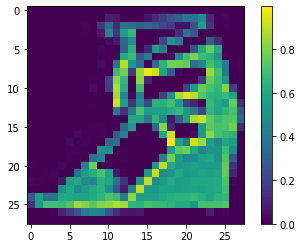

Class:  Sandal


In [10]:
test_data = torchvision.datasets.FashionMNIST(root="data", train=False, transform=torchvision.transforms.ToTensor())
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
img, lbl = next(iter(test_dataloader))
img = img.reshape(1, 28, 28).numpy()

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class: ", class_names[lbl[0]])

In [11]:
ex = relax.vm.build(MLPModelFinal, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())
data_nd = tvm.nd.array(img.reshape(1, -1))

nd_res = vm["main"](data_nd)
pred = np.argmax(nd_res.numpy(), axis=1)[0]
print("PRED: ", class_names[pred])

PRED:  Sandal
